# network model with Mesa

Links

* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://networkx.github.io/documentation/stable/reference/drawing.html
* https://stackoverflow.com/questions/63681056/visualizing-agents-using-mesa-networkx

In [1]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx


In [2]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

In [4]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = int(self.random.normalvariate(20,40))
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        for a in susceptible_neighbors:
            if self.random.random() < model.ptrans:
                a.state = State.INFECTED
                a.recovery_time = model.get_recovery_time()
                                
    def step(self):
        self.status()
        self.move()
        self.contact()
        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

## Infection model

In [5]:
#?nx.erdos_renyi_graph

In [6]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, ptrans=0.5, avg_node_degree=3,
                 progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21,
                 recovery_sd=7):
        
        #self.num_agents = N
        self.num_nodes = N  
        prob = avg_node_degree / self.num_nodes
        
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.grid = NetworkGrid(self.G)
        
        self.schedule = RandomActivation(self)
        self.running = True
        #self.dead_agents = []
        
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.99,0.01])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [7]:
model = NetworkInfectionModel(300, ptrans=0.2)
model.step()
model

In [8]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f

In [9]:
pop=30
steps=50
st=time.time()
model = NetworkInfectionModel(pop, ptrans=0.05)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

0.01534271240234375
      Susceptible  Infected  Removed
Step                                
0              30         0        0
1              26         4        0
2              25         5        0
3              23         7        0
4              20        10        0
5              19        11        0
6              16        14        0
7              12        18        0
8              11        19        0
9              10        20        0


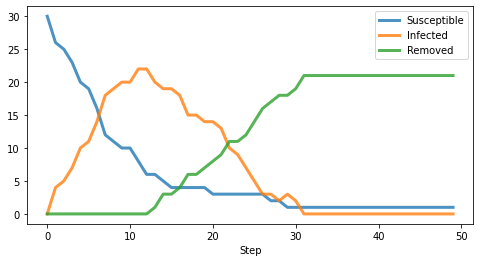

In [10]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

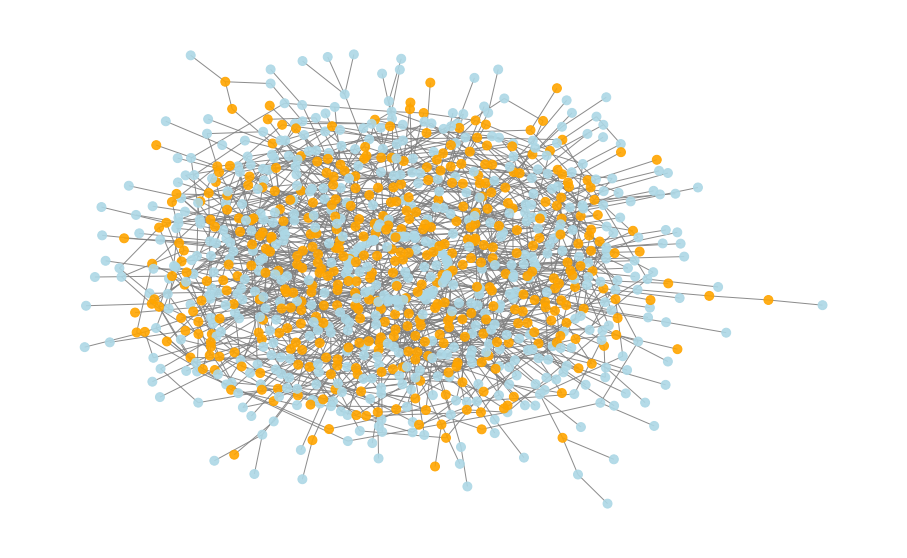

In [11]:
      
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
    #print (cells[:10])
    #print (pos)
    #print (pd.Series(states).value_counts())
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=80, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    #print (ax.patches)
    #ax.legend(['S','I','R'])
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = NetworkInfectionModel(1000, ptrans=0.1)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

In [12]:
def run_model(pop, ptrans, degree, steps, delay, layout):

    model = NetworkInfectionModel(pop, ptrans=ptrans, avg_node_degree=degree)

    #fig,ax=plt.subplots(1,1,figsize=(10,8))
    fig1 = plt.Figure(figsize=(8,6))
    #ax1=fig1.add_subplot(1,1,1,label='a')
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    
#run_model(50, 20, 1, 20, 1)

In [13]:
grid_pane = pn.pane.Matplotlib()
states_pane = pn.pane.Matplotlib()
go_btn = pnw.Button(name='run',width=100,button_type='primary')
pop_input = pnw.IntSlider(name='population',value=100,start=10,end=1000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets = pn.WidgetBox(go_btn,pop_input,ptrans_input,degree_input,steps_input,delay_input,layout_input)

def execute(event):
    run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')
    
pn.Row(pn.Column(widgets),grid_pane,states_pane)

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='run', width=100)
            [1] IntSlider(end=1000, name='population', start=10, step=10, value=100, width=100)
            [2] FloatSlider(name='prob. trans', value=0.1, width=100)
            [3] IntSlider(end=10, name='node degree', start=1, value=3, width=100)
            [4] IntSlider(end=100, name='steps', start=5, value=20, width=100)
            [5] FloatSlider(end=3, name='delay', step=0.2, value=0.2, width=100)
            [6] Select(name='layout', options=['spring', 'circular', ...], value='spring', width=100)
    [1] Matplotlib(None)
    [2] Matplotlib(None)

In [14]:
import pygraphviz as pgv
A = nx.nx_agraph.to_agraph(model.G)
A.layout() 
#A.draw()

ModuleNotFoundError: No module named 'pygraphviz'